In [1]:
import torch
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from pathlib import Path
from random import sample
from functools import partial
from sklearn.manifold import TSNE
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR, SVR
from hyperopt import STATUS_OK, fmin, tpe, hp
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from transformers import ConvNextImageProcessor, ConvNextForImageClassification, AutoImageProcessor, AutoModel

c:\Users\fmore\anaconda3\envs\envnestedai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator, TransformerMixin

class Transformer(ABC, BaseEstimator, TransformerMixin):

    @abstractmethod
    def __init__(self):
        super().__init__()

    @abstractmethod
    def fit(self, X: pd.DataFrame, y=None):
        pass

    @abstractmethod
    def transform(self, X: pd.DataFrame):
        pass

class Nothing(Transformer):
    def __init__(self):
        # TODO
        pass

    def fit(self, X, y=None):

        # TODO

        return self

    def transform(self, X):

        # TODO

        return X

# Text ONLY

In [ ]:
txt_dataset_path = Path("./data/global_df.csv")

## Preparation

In [ ]:
df = pd.read_csv(txt_dataset_path, index_col=0)

In [ ]:
cols_to_keep = ["Number of Bedrooms", "Number of bathrooms", "Area", "density", "population", "city", "Price"]
df = df[cols_to_keep]

In [ ]:
target = "Price"

X = df.drop(columns=[target])
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
# max_price = y.max()
# y_train = y_train/max_price
# y_test = y_test/max_price

In [ ]:
encoded_var = ["city"]
numerical_var = X.columns.drop(encoded_var)

In [ ]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

## Model Training

### SVR

In [ ]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", SVR())
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

### Random forest

In [ ]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", RandomForestRegressor())
])

In [ ]:
parameters = {
    "transformer__cat__max_categories": [4, 8, 11, 14],
    "estimator__max_depth": [None, 3, 5, 7],
    "estimator__n_estimators": [50, 100, 150, 200],
    "estimator__criterion": ['squared_error', 'absolute_error']
}

grid = GridSearchCV(pipeline, parameters, verbose=1)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)*max_price**2}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)*max_price}")

In [ ]:
# Feature importance
dict(
    sorted(
        zip(
            pipeline[0].get_feature_names_out(),
            pipeline[-1].feature_importances_
        ),
    key=lambda x: x[1],
    reverse=True)
)

### LinearSVR

In [ ]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", LinearSVR())
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

### xgBoost

#### No hyperparameters tuning

In [ ]:
data_pipeline = Pipeline([
    ('transform', transformer)
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.01,
    'n_estimators': 1000,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

#### Hyperparameters Tuning

In [ ]:
data_pipeline = Pipeline([
    ('transform', transformer)
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

In [ ]:
# Define the hyperparameter space
search_space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 10e1),
    'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
    'reg_lambda' : hp.uniform("reg_lambda", 0,1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
    'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
    'max_delta_step' : hp.choice("max_delta_step", np.arange(1,10,1,dtype='int')),
    'subsample' : hp.uniform("subsample",0.5,1),
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
    'seed' : 44
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train_processed, y_train)
    y_pred = xgb_model.predict(X_test_processed)
    score = mean_squared_error(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, search_space, algo=tpe.suggest, max_evals=200)
print("Best set of hyperparameters: ", best_params)

In [ ]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)

print(f"MSE : {(mean_squared_error(y_test, y_pred)*(max_price**2)*1e-9).round(6)}*10^9")
print(f"MAE : {mean_absolute_error(y_test, y_pred)*max_price}")
print(f"R2 : {r2_score(y_test, y_pred)}")

# Image ONLY

In [ ]:
txt_dataset_path = Path("./data/global_df.csv")
img_features_dataset_path = Path("./data/img_features_dataset_dinoV2_small.csv")

## Preparation

In [ ]:
txt_dataset = pd.read_csv(txt_dataset_path)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

img_features_dataset.index = [int(idx.replace("_house", ""))-1 for idx in img_features_dataset.index]


df = pd.merge(txt_dataset[["Price"]], img_features_dataset, left_index=True, right_index=True)

In [ ]:
correlations = df.corr()['Price'].abs()
sorted_features = correlations.sort_values(ascending=False)
important_features = sorted_features[:16].drop('Price')
important_features

In [ ]:
target = "Price"

X = df[important_features.index]
y = df[[target]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data_pipeline = Pipeline([
    ('standardization', StandardScaler()),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

## Model Training

In [ ]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.001,
    'n_estimators': 2000,
    'gamma': 1e-2,
    'max_depth': 2,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)

In [ ]:
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

In [ ]:
bst.get_booster().get_score(importance_type='weight')

# Text + Image (Augmented dataset)

In [ ]:
txt_dataset_path = Path("./data/global_df_augm.csv")
img_features_dataset_path = Path("./data/img_IMPORTANT_features_augm_dataset_dinoV2_small.csv")

## Preparation

In [ ]:
txt_dataset = pd.read_csv(txt_dataset_path, index_col='ID_augm')
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

df = pd.merge(txt_dataset, img_features_dataset, left_index=True, right_index=True)

In [ ]:
test_size = int(df.shape[0]//2 * 0.2)
test_ids = sample(range(1, df.shape[0]//2 + 1), test_size)
test_ids = [str(idx) + "_1" for idx in test_ids] + [str(idx) + "_2" for idx in test_ids]

In [ ]:
target = "Price"

X = df.drop(columns=[target])
y = df[target]

X_train = X[~X.index.isin(test_ids)]
y_train = y[~y.index.isin(test_ids)]

X_test = X[X.index.isin(test_ids)]
y_test = y[y.index.isin(test_ids)]

In [ ]:
encoded_var = ["city"]
img_features = [col for col in X.columns if col.startswith("feature_")]
numerical_var = X.columns.drop(encoded_var + img_features).to_list()

In [ ]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=5, handle_unknown='infrequent_if_exist'), encoded_var),
    ("img_features", Nothing(), img_features),
])

## Model Training

In [ ]:
data_pipeline = Pipeline([
    ('transform', transformer),
    ('pca', PCA(n_components=10))
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.005,
    'n_estimators': 3000,
    'max_depth': 6
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

# Text + Image (simple dataset)

In [11]:
txt_dataset_path = Path("./data/global_df.csv")
img_features_dataset_path = Path("./data/img_x4_IMPORTANT_features_dataset_dinoV2_small.csv")

## Preparation

In [43]:
txt_dataset = pd.read_csv(txt_dataset_path, index_col=0)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density", "lat", "lng"]
txt_dataset = txt_dataset[txt_cols]

In [44]:
nb_img_features_to_keep = 20
img_features_dataset = img_features_dataset.iloc[:, :nb_img_features_to_keep]

In [45]:
df = pd.merge(txt_dataset, img_features_dataset, left_index=True, right_index=True)
assert df.shape[0] == 535
df.head()

,Number of Bedrooms,Number of bathrooms,Area,Price,city,population,density,lat,lng,feature_kitchen_243,...,feature_kitchen_369,feature_bedroom_84,feature_kitchen_186,feature_bedroom_365,feature_kitchen_42,feature_bedroom_360,feature_bathroom_372,feature_kitchen_288,feature_bedroom_199,feature_bedroom_372
1,4,4.0,4053,869500,Scottsdale,43685.0,191.20000,33.682400,-111.817700,-1.441806,...,2.845753,-5.146580,-0.101273,5.982801,6.311833,-5.117402,-3.199631,3.897140,-4.422895,-5.765283
2,4,3.0,3343,865200,UNKNOWN,18669.0,695.56236,35.233552,-116.742111,3.131124,...,3.505777,-3.525192,2.060034,0.372031,4.181828,-4.604251,-2.980280,4.133832,-1.107460,-2.926953
3,3,4.0,3923,889000,Scottsdale,12187.0,239.90000,33.760340,-111.925030,0.682695,...,3.410797,-6.166311,1.593972,2.489098,2.754976,-3.913920,-4.680387,5.811798,-4.041443,-2.937681
4,5,5.0,4022,910000,Scottsdale,13126.0,32.70000,33.858340,-111.801690,2.826478,...,5.220740,-0.912623,1.508615,2.815121,4.989522,-1.513232,-3.004798,5.143368,-0.305088,1.713992
5,3,4.0,4116,971226,Scottsdale,12187.0,239.90000,33.760340,-111.925030,1.154137,...,4.479376,-5.298474,1.727362,5.038130,3.907297,-6.360377,-3.233636,5.524505,-5.954932,-3.879755


In [46]:
target = "Price"

X = df.drop(columns=target)
y = df[[target]]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
normalizer = MinMaxScaler(feature_range=(0, 1))
y_train = normalizer.fit_transform(y_train)
y_test = normalizer.transform(y_test)

In [49]:
encoded_var = ["city"]
img_features = img_features_dataset.columns.to_list()
numerical_var = X.columns.drop(encoded_var + img_features).to_list()

In [20]:
class PartialPCA(Transformer):
    def __init__(self, columns: list[str], n_components: int):
        self.columns = columns
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.pca_features = [f"pca_{i}" for i in range(self.n_components)]

    def fit(self, X, y=None):

        self.pca.fit(X[self.columns])

        return self
    
    def transform(self, X):

        X_pca_array = self.pca.transform(X[self.columns])
        X_pca_df = pd.DataFrame(X_pca_array, columns=self.pca_features, index=X.index)

        cols_to_drop = [col for col in X.columns if col.startswith("feature_")]

        X = pd.merge(X.drop(columns=cols_to_drop), X_pca_df, left_index=True, right_index=True)

        return X

#### With PCA

In [ ]:
pca_n_components = 5
pca_features = [f"pca_{i}" for i in range(pca_n_components)]

transformer = ColumnTransformer(transformers=[
    ("num", MinMaxScaler(), numerical_var + img_features),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

data_pipeline = Pipeline([
    ('pca_img_features', PartialPCA(columns=img_features, n_components=pca_n_components)),
    ('transform', transformer),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

#### Without PCA

In [50]:
transformer = ColumnTransformer(transformers=[
    ("num", MinMaxScaler(), numerical_var + img_features),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
], remainder='passthrough')

data_pipeline = Pipeline([
    ('transform', transformer),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,...,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.263240,0.275604,0.186999,0.308870,0.100952,0.166224,0.154257,0.434023,0.484496,0.485315,...,0.091121,0.023364,0.049065,0.021028,0.098131,0.028037,0.051402,0.023364,0.200935,0.140187
std,0.127887,0.165189,0.139160,0.253105,0.150427,0.154546,0.161659,0.149913,0.242698,0.195146,...,0.288119,0.151235,0.216257,0.143646,0.297840,0.165273,0.221074,0.151235,0.401168,0.347587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.166667,0.083202,0.072081,0.004834,0.079742,0.048984,0.332437,0.261548,0.345472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.222222,0.250000,0.153738,0.176586,0.012207,0.085584,0.139593,0.430540,0.510467,0.484205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.333333,0.333333,0.265087,0.450279,0.156925,0.200130,0.175274,0.537638,0.686521,0.612493,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model Training

#### Random Foret

In [ ]:
pipeline = Pipeline([
    ("data_pipeline", data_pipeline),
    ("estimator", RandomForestRegressor())
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

### XGbosst

#### Without Hyperparameters tuning

In [51]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.04,
    'n_estimators': 1000,
    'max_depth': 4,
    'subsample': 0.89,
    'colsample_bytree': 0.5,
    'min_child_weight': 2,
    'eta': 0.8,
    'gamma': 44,
    'reg_alpha': 8.4,
    'reg_lambda': 0.96
}



model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.08961	validation_1-rmse:0.06263
[1]	validation_0-rmse:0.08733	validation_1-rmse:0.06115


[2]	validation_0-rmse:0.08512	validation_1-rmse:0.05974
[3]	validation_0-rmse:0.08288	validation_1-rmse:0.05813
[4]	validation_0-rmse:0.08071	validation_1-rmse:0.05668
[5]	validation_0-rmse:0.07863	validation_1-rmse:0.05554
[6]	validation_0-rmse:0.07658	validation_1-rmse:0.05423
[7]	validation_0-rmse:0.07462	validation_1-rmse:0.05327
[8]	validation_0-rmse:0.07271	validation_1-rmse:0.05215
[9]	validation_0-rmse:0.07078	validation_1-rmse:0.05134
[10]	validation_0-rmse:0.06902	validation_1-rmse:0.05054
[11]	validation_0-rmse:0.06736	validation_1-rmse:0.04979
[12]	validation_0-rmse:0.06561	validation_1-rmse:0.04934
[13]	validation_0-rmse:0.06391	validation_1-rmse:0.04890
[14]	validation_0-rmse:0.06244	validation_1-rmse:0.04816
[15]	validation_0-rmse:0.06095	validation_1-rmse:0.04762
[16]	validation_0-rmse:0.05937	validation_1-rmse:0.04675
[17]	validation_0-rmse:0.05782	validation_1-rmse:0.04589
[18]	validation_0-rmse:0.05653	validation_1-rmse:0.04527
[19]	validation_0-rmse:0.05507	validati

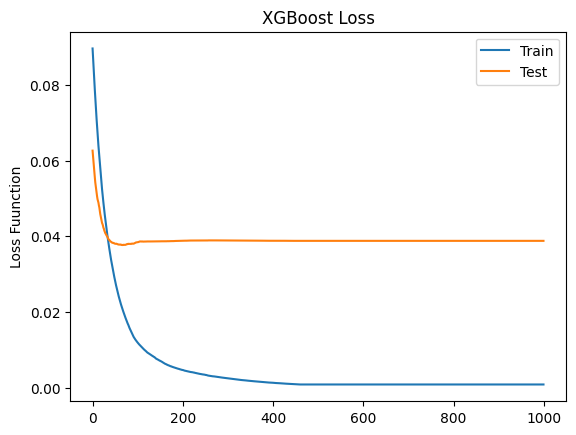

In [53]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [54]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

MSE : 0.0015056845004554863
MAE : 0.02647938025923434
R2 : 0.6296292956663594


In [ ]:
bst.get_booster().get_score(importance_type='weight')

#### Hyperparameters Tuning

In [22]:
def objective(X_train_, X_test_, y_train_, y_test_, trial):
    
    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        'eval_metric' : 'rmse',
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        'eta'      : trial.suggest_float("eta", 0, 1),
        'gamma'    : trial.suggest_float("gamma", 0, 15e1),
        'reg_alpha': trial.suggest_float("reg_alpha", 10e-7, 10),
        'reg_lambda' : trial.suggest_float("reg_lambda", 0,1),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_, y_train_, verbose=False)
    predictions = model.predict(X_test_)
    rmse = mean_squared_error(y_test_, predictions)
    
    return rmse


partial_objective = partial(objective, X_train_processed, X_test_processed, y_train, y_test)

In [17]:
study = optuna.create_study(
    direction='minimize',
)

study.optimize(partial_objective, n_trials=500)

[I 2024-12-12 03:06:57,995] A new study created in memory with name: no-name-00108392-41e4-4090-a124-c1b54d4f1170
[I 2024-12-12 03:06:59,469] Trial 0 finished with value: 0.004131761347982103 and parameters: {'n_estimators': 975, 'learning_rate': 0.00717509766717635, 'max_depth': 2, 'subsample': 0.17078016455309453, 'colsample_bytree': 0.2206415863511889, 'min_child_weight': 2, 'eta': 0.008112680029287223, 'gamma': 40.70470333768, 'reg_alpha': 1.8159025392110664, 'reg_lambda': 0.8798892710985595}. Best is trial 0 with value: 0.004131761347982103.
[I 2024-12-12 03:07:00,281] Trial 1 finished with value: 0.004127943097417724 and parameters: {'n_estimators': 467, 'learning_rate': 0.007388104091457635, 'max_depth': 3, 'subsample': 0.976890319795478, 'colsample_bytree': 0.5067169841946562, 'min_child_weight': 10, 'eta': 0.25281671992861554, 'gamma': 64.57482312804014, 'reg_alpha': 9.55065253116786, 'reg_lambda': 0.8180311714204991}. Best is trial 1 with value: 0.004127943097417724.
[I 2024-

In [ ]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

params = study.best_params | {
    "objective": "reg:squarederror",
    'eval_metric' : 'rmse',
}

model = xgb.XGBRegressor(**params)
model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

y_test_pred = model.predict(X_test_processed)

In [ ]:
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R2 : {r2_score(y_test, y_test_pred)}")

In [ ]:
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

## Preparation + Model Training : for image features tuning

Goal : find out what is the optimal number of image features to insert in the model

In [6]:
txt_dataset = pd.read_csv(txt_dataset_path, index_col=0)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density", "lat", "lng"]
txt_dataset = txt_dataset[txt_cols]

In [7]:
df = pd.merge(txt_dataset, img_features_dataset, left_index=True, right_index=True)
assert df.shape[0] == 535

In [8]:
target = "Price"

X = df.drop(columns=target)
y = df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
normalizer = MinMaxScaler(feature_range=(0, 1))
y_train = normalizer.fit_transform(y_train)
y_test = normalizer.transform(y_test)

In [10]:
NB_FEATURES = []
MSE = []
R2 = []

for nb in range(0,img_features_dataset.shape[1], 20):

    nb: int #number of important image features to keep

    img_features_cols = img_features_dataset.columns[:nb]


    encoded_var = ["city"]
    img_features = img_features_cols.to_list()
    numerical_var = X.columns.drop(encoded_var + img_features).to_list()

    X_train_reduced = X_train[encoded_var + img_features + numerical_var]
    X_test_reduced = X_test[encoded_var + img_features + numerical_var]

    transformer = ColumnTransformer(transformers=[
        ("num", MinMaxScaler(), numerical_var + img_features),
        ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
    ], remainder='passthrough')

    data_pipeline = Pipeline([
        ('transform', transformer),
    ])

    X_train_processed = data_pipeline.fit_transform(X_train_reduced)
    X_test_processed = data_pipeline.transform(X_test_reduced)

    ## MODEL

    eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
    eval_metric = ['rmse']

    params = {
        'objective': 'reg:squarederror',  # For regression tasks
        'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
        'learning_rate': 0.04,
        'n_estimators': 600,
        'max_depth': 4,
        'subsample': 0.89,
        'colsample_bytree': 0.5,
        'min_child_weight': 2,
        'eta': 0.8,
        'gamma': 44,
        'reg_alpha': 8.4,
        'reg_lambda': 0.96,
    }

    model = xgb.XGBRegressor()
    model.set_params(
        objective=params['objective'],
        eval_metric=params['eval_metric'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators']
    )

    bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=False)

    y_pred = model.predict(X_test_processed)

    NB_FEATURES.append(nb)
    MSE.append(mean_squared_error(y_test, y_pred))
    R2.append(r2_score(y_test, y_pred))

    print(round(nb/img_features_dataset.shape[1], 0), " %")


0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %
0.0  %


KeyboardInterrupt: 

In [32]:
min(MSE)

np.float64(0.0013602818001255208)

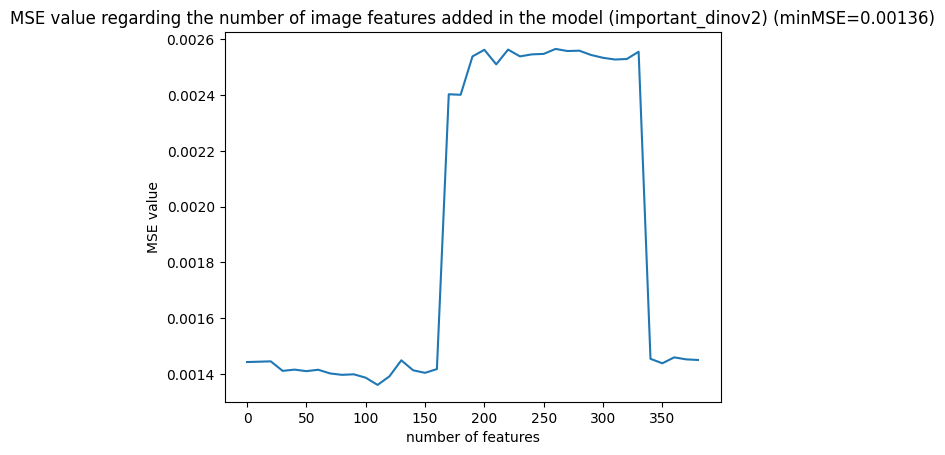

In [34]:
plt.plot(NB_FEATURES, MSE)
plt.title("MSE value regarding the number of image features added in the model (important_dinov2) (minMSE=0.00136)")
plt.xlabel("number of features")
plt.ylabel("MSE value")
plt.show()

In [30]:
max(R2)

0.6653956866446364

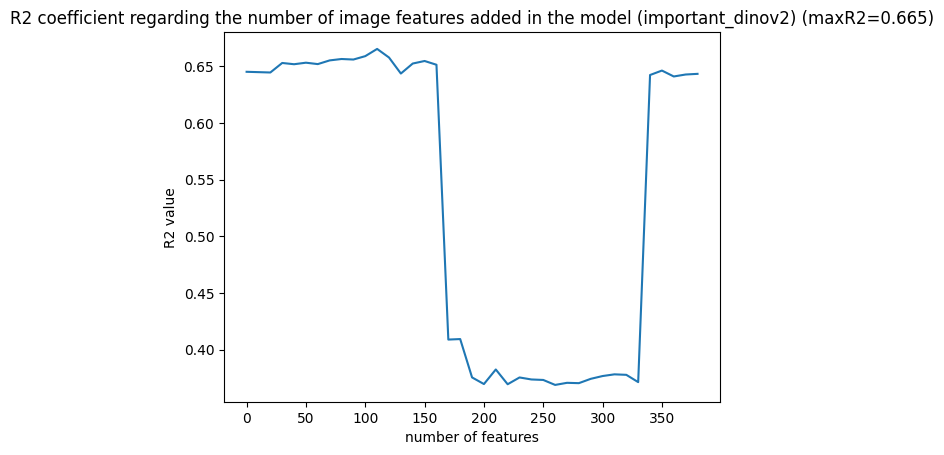

In [35]:
plt.plot(NB_FEATURES, R2)
plt.title("R2 coefficient regarding the number of image features added in the model (important_dinov2) (maxR2=0.665)")
plt.xlabel("number of features")
plt.ylabel("R2 value")
plt.show()

# Text + Image X4 (simple dataset)

Previously, images features are extracted from each image separatly, and then concatenated in a single vector

In [3]:
txt_dataset_path = Path("./data/global_df.csv")
img_features_dataset_path = Path("./data/img_x4_IMPORTANT_features_dataset_dinoV2_small.csv")

## Preparation

In [ ]:
txt_dataset = pd.read_csv(txt_dataset_path)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

img_features_dataset.index = [int(idx.replace("_house", ""))-1 for idx in img_features_dataset.index]

In [ ]:
n_components=10
tsne = TSNE(n_components=n_components, method="exact")
img_features_tsne = tsne.fit_transform(img_features_dataset)

img_features_tsne_df = pd.DataFrame(img_features_tsne)
img_features_tsne_df.columns = ["tsne_img_feature_" + str(col) for col in img_features_tsne_df.columns]

In [ ]:
df = pd.merge(txt_dataset, img_features_tsne_df, left_index=True, right_index=True)

In [ ]:
target = "Price"

X = df.drop(columns=target)
y = df[[target]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# max_price = y.max().item()
# y_train = y_train/max_price
# y_test = y_test/max_price

In [ ]:
encoded_var = ["city"]
img_features = img_features_tsne_df.columns.to_list()
numerical_var = X.columns.drop(encoded_var + img_features).to_list()

In [ ]:
class PartialTSNE(Transformer):
    def __init__(self, columns: list[str], n_components: int):
        self.columns = columns
        self.n_components = n_components
        self.tsne = TSNE(n_components=self.n_components)
        self.tsne_features = [f"tsne_{i}" for i in range(self.n_components)]

    def fit(self, X, y=None):

        self.tsne.fit(X[self.columns])

        return self
    
    def transform(self, X):

        X_tsne_array = self.tsne.transform(X[self.columns])
        X_tsne_df = pd.DataFrame(X_tsne_array, columns=self.tsne_features, index=X.index)

        cols_to_drop = [col for col in X.columns if col.startswith("feature_")]

        X = pd.merge(X.drop(columns=cols_to_drop), X_tsne_df, left_index=True, right_index=True)

        return X

In [ ]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var + img_features),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

data_pipeline = Pipeline([
    # ('tsne_img_features', PartialTSNE(columns=img_features, n_components=tsne_n_components)),
    ('transform', transformer),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

## Models

### XGBoost

In [ ]:
def objective(X_train_, X_test_, y_train_, y_test_, trial):
    
    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        'eval_metric' : 'rmse',
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        'eta'      : trial.suggest_float("eta", 0, 1),
        'gamma'    : trial.suggest_float("gamma", 0, 15e1),
        'reg_alpha': trial.suggest_float("reg_alpha", 10e-7, 10),
        'reg_lambda' : trial.suggest_float("reg_lambda", 0,1),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_, y_train_, verbose=False)
    predictions = model.predict(X_test_)
    rmse = root_mean_squared_error(y_test_, predictions)
    
    return rmse


partial_objective = partial(objective, X_train_processed, X_test_processed, y_train, y_test)

In [ ]:
study = optuna.create_study(
    direction='minimize',
)

study.optimize(partial_objective, n_trials=200)

In [ ]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

params = study.best_params | {
    "objective": "reg:squarederror",
    'eval_metric' : 'rmse',
}

model = xgb.XGBRegressor(**params)
model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

y_test_pred = model.predict(X_test_processed)

In [ ]:
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R2 : {r2_score(y_test, y_test_pred)}")

In [ ]:
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

### Neural Network torch

In [ ]:
lr = 0.001
momentum = 0.9
batch_size = 5
nb_epoch = 2000

In [ ]:
X_train_torch = torch.from_numpy(X_train_processed).float()
y_train_torch = torch.from_numpy(y_train.to_numpy()).float()
y_train_torch = y_train_torch.view(len(y_train), 1)

In [ ]:
trainloader = torch.utils.data.DataLoader(X_train_processed, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(X_test_processed, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size: int):
        super(Net, self).__init__()

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(input_size, 128)

        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):

        x = self.dropout1(x)
        x = F.relu(self.fc1(x))

        x = self.dropout2(x)
        x = F.relu(self.fc2(x))

        output = self.fc3(x)

        return output

model = Net(input_size=X_train_processed.shape[1])
print(model)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
loss_l = []
for num_epoch in range(nb_epoch):

    y_train_pred = model(X_train_torch)
    loss = criterion(y_train_pred, y_train_torch)

    model.zero_grad()
    loss.backward()
    optimizer.step()


    loss_l.append(loss.item())
    if num_epoch % 1 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

### Neural Network sklearn

In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=(X_train_processed.shape[1], 10, 1),
    learning_rate="adaptive",
    learning_rate_init=0.001,   
)

pipeline = Pipeline([
    ('data_pipeline', data_pipeline),
    ('MLP', mlp),
])

In [ ]:
pipeline.fit(X_train, y_train.values.ravel())

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

In [ ]:
pipeline[-1].validation_scores_

In [ ]:
plt.plot(pipeline[-1].loss_curve_)
plt.show()

# Text + Image (CNN + NN from scratch)

In [3]:
txt_dataset_path = Path("./data/global_df.csv")
img_dataset_path = Path("./data/concatenated_images_224px")

## Preparation

### Text Preparation

In [4]:
txt_dataset = pd.read_csv(txt_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

In [5]:
target = "Price"

X = txt_dataset.drop(columns=target)
y = txt_dataset[[target]]

In [6]:
encoded_var = ["city"]
numerical_var = X.columns.drop(encoded_var).to_list()

In [7]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [8]:
normalizer = MinMaxScaler(feature_range=(0, 1))
y_text_train_processed = normalizer.fit_transform(y_text_train)
y_text_test_processed = normalizer.transform(y_text_test)

In [10]:
transformer = ColumnTransformer(transformers=[
    ("num", MinMaxScaler((0, 1)), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

data_pipeline = Pipeline([
    ('transform', transformer),
])

X_text_train_processed = data_pipeline.fit_transform(X_text_train)
X_text_test_processed = data_pipeline.transform(X_text_test)

In [11]:
X_text_train_processed

array([[0.11111111, 0.16666667, 0.08320198, ..., 0.        , 1.        ,
        0.        ],
       [0.22222222, 0.16666667, 0.10121594, ..., 0.        , 0.        ,
        1.        ],
       [0.33333333, 0.33333333, 0.21571718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.22222222, 0.16666667, 0.15841027, ..., 0.        , 0.        ,
        0.        ],
       [0.44444444, 0.33333333, 0.39394281, ..., 0.        , 0.        ,
        0.        ],
       [0.11111111, 0.16666667, 0.08320198, ..., 0.        , 1.        ,
        0.        ]])

### Image Preparation

In [12]:
images= {
    int(img_path.stem.replace("_house", "")) : Image.open(img_path)
    for img_path in img_dataset_path.iterdir()
}

In [13]:
images_train = [images[idx] for idx in X_text_train.index]
images_test = [images[idx] for idx in X_text_test.index]

assert len(images_train) + len(images_test) == len(images) == 535

In [14]:
t = transforms.ToTensor()
im = t(images_train[1])
im.shape

torch.Size([3, 448, 448])

In [15]:
images_train[1].size

(448, 448)

### Dataset set up

In [16]:
from torch.utils.data import DataLoader, Dataset
import numpy as np

class ImageStructuredDataset(Dataset):
    def __init__(self, image_list, structured_data, labels):
        """
        Args:
            image_list (list of PIL.Image): List of PIL images.
            structured_data (pd.DataFrame): DataFrame with structured features.
            labels (list or pd.Series): List or Series with labels.
        """
        self.transformers = transforms.ToTensor()
        self.image_list = [self.transformers(img) for img in image_list]
        self.structured_data = torch.tensor(structured_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).flatten()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):

        img = self.image_list[idx]
        struct = self.structured_data[idx]
        label = self.labels[idx]

        return img, struct, label

    
train_dataset = ImageStructuredDataset(images_train, X_text_train_processed, y_text_train_processed)
test_dataset = ImageStructuredDataset(images_test, X_text_test_processed, y_text_test_processed)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
train_dataset.__getitem__(1)

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843],
          [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9882, 0.9843],
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9961, 0.9882],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.7647, 0.5255, 0.8471],
          [1.0000, 1.0000, 1.0000,  ..., 0.4471, 0.6549, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9882, 0.9922]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.5255, 0.8471],
          [1.0000, 1.0000, 1.0000,  ..., 0.4471, 0.6549, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9882, 0.9922]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9843, 0.9843],
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9843, 0.9843],
          [1.0000, 1.0000, 1.0000,  ...,

## Model

In [18]:
class Model(nn.Module):
    def __init__(self, img_output_dim=128, structured_input_dim=10, fc_hidden_dim=64, num_outputs=1):
        super(Model, self).__init__()
        
        # CNN for image processing
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling to get a fixed size
        )
        
        # Fully connected layer for CNN output
        self.fc_img = nn.Linear(64*4*4, img_output_dim)
        
        # Fully connected layers for structured data
        self.fc_struct = nn.Sequential(
            nn.Linear(structured_input_dim, fc_hidden_dim),
            nn.ReLU(),
            nn.Linear(fc_hidden_dim, fc_hidden_dim),
            nn.ReLU()
        )
        
        # Final regression layer
        self.fc_combined = nn.Sequential(
            nn.Linear(img_output_dim + fc_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_outputs)
        )
        
    def forward(self, img, structured_data):
        # Image processing
        img_features = self.cnn(img)
        img_features = img_features.view(img_features.size(0), -1)
        img_features = F.relu(self.fc_img(img_features))
        
        # Structured data processing
        struct_features = self.fc_struct(structured_data)
        
        # Combine both features
        combined_features = torch.cat((img_features, struct_features), dim=1)
        
        # Final regression output
        output = self.fc_combined(combined_features)
        return output

# Example model initialization
model = Model(img_output_dim=64, structured_input_dim=19, fc_hidden_dim=64, num_outputs=1)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (fc_img): Linear(in_features=1024, out_features=64, bias=True)
  (fc_struct): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [22]:
num_epochs = 2
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, structs, targets in train_loader:
        imgs, structs, targets = imgs.to(device), structs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(imgs, structs).squeeze()
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/2], Loss: 0.0050
Epoch [2/2], Loss: 0.0046


In [21]:
model.eval()
test_loss = 0
with torch.no_grad():
    for imgs, structs, targets in test_loader:
        imgs, structs, targets = imgs.to(device), structs.to(device), targets.to(device)
        outputs = model(imgs, structs).squeeze()
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
test_losses.append(avg_test_loss)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0017


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

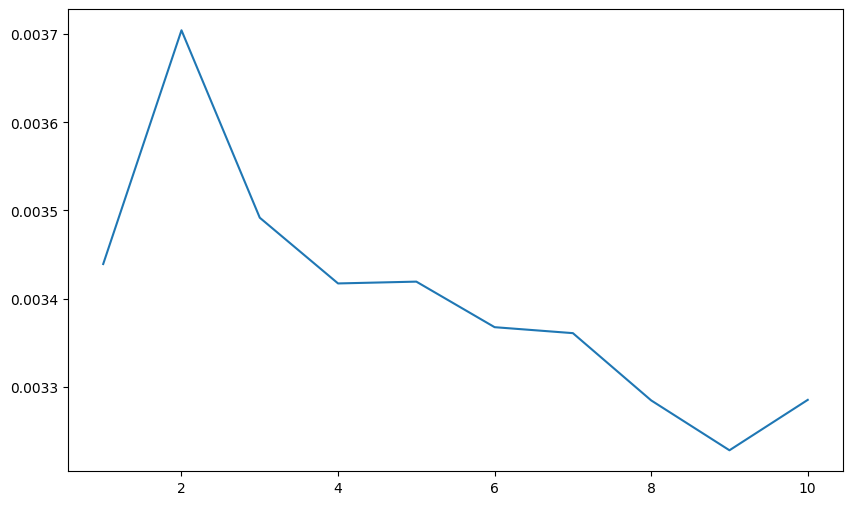

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()